In [1]:
import os
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.utils.data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from torchvision.datasets import ImageFolder
from PIL import Image

class CelebA(torch.utils.data.Dataset):
    def __init__(self, image_dir, attr_path, selected_attrs, transform, mode):
        self.image_dir = image_dir
        self.attr_path = attr_path
        self.selected_attrs = selected_attrs
        self.transform = transform
        self.mode = mode
        self.train_dataset = []
        self.test_dataset = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        lines = [line.rstrip() for line in open(self.attr_path, 'r')]
        all_attr_names = lines[0].split(',')
        for i, attr_name in enumerate(all_attr_names):
            if attr_name == 'image_id':
                continue
            self.attr2idx[attr_name] = i - 1
            self.idx2attr[i - 1] = attr_name
            
        lines = lines[1:]
        random.seed(1234)
        random.shuffle(lines)
        for i, line in enumerate(lines):
            split = line.split(',')
            filename = split[0]
            values = split[1:]
            
            label = []
            
            for attr_name in self.selected_attrs:
                idx = self.attr2idx[attr_name]
                label.append(values[idx] == '1')

            if (i+1) < 2000:
                self.test_dataset.append([filename, label])
            else:
                self.train_dataset.append([filename, label])

        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        filename, label = dataset[index]
        image = Image.open(os.path.join(self.image_dir, filename))
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images

In [4]:
img_path       = 'img_align_celeba'
attr_path      = 'list_attr_celeba.csv'
selected_attrs = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']

from torchvision import transforms
crop_size=178
image_size=128
batch_size=2

transform = transforms.Compose([transforms.RandomHorizontalFlip(), 
             transforms.CenterCrop(crop_size), 
             transforms.Resize(image_size), transforms.ToTensor(),
             transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

mode='train'
dataset = CelebA(img_path, 
                 attr_path, 
                 selected_attrs, 
                 transform,
                 mode)

Finished preprocessing the CelebA dataset...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


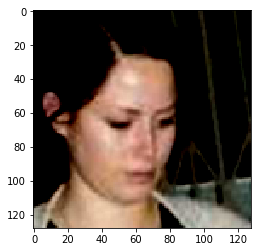

In [38]:
plt.imshow(image.detach().cpu().permute(1, 2, 0).numpy())

In [5]:
dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size,
                                         shuffle=(mode=='train'))

In [6]:
class StarWGAN(object):
    def __init__(self, dataloader, discriminator, generator, dis_optimizer, gen_optimizer, save_images_path='./stargan_images'):
        self.dataloader    = dataloader
        self.discriminator = discriminator
        self.generator     = generator
        self.dis_optimizer = dis_optimizer
        self.gen_optimizer = gen_optimizer
        self.save_images_path = save_images_path
        
        self.start_iters = 0

        self.num_iters_decay = 100000
        self.lr_update_step = 1000
        self.n_critic = 5       
        
    def gradient_penalty(self, y, x, lambda_gp=10):
        grads  = torch.autograd.grad(outputs=y,
                                     inputs=x,
                                     grad_outputs=torch.ones_like(y),
                                     retain_graph=True,
                                     create_graph=True,
                                     only_inputs=True)[0]
        loss = ((grads.norm(2, dim=1) - 1) ** 2).mean()

        return loss * lambda_gp
    
    def update_lr(self, i, num_iters):
            if (i + 1) % self.lr_update_step == 0 and (i + 1) > (num_iters - self.num_iters_decay):
                for param_group in gen_optimizer.param_groups:
                    gen_lr = param_group['lr']
                    gen_lr -= (gen_lr / float(self.num_iters_decay))
                    param_group['lr'] = gen_lr
                    
                for param_group in dis_optimizer.param_groups:
                    dis_lr = param_group['lr']
                    dis_lr -= (dis_lr / float(self.num_iters_decay))
                    param_group['lr'] = dis_lr

    def save_image(self, i, x_fake):
        if i % 1000 == 0:
            torchvision.utils.save_image(x_fake.data,
                                             '%s/%d.png' % (self.save_images_path, i),
                                             normalize=True)
            
    def train(self, num_iters):
        start_iters = self.start_iters
        
        for i in range(start_iters, num_iters):
            self.start_iters += 1
            
            try:
                x_real, label_org = next(data_iter)
            except:
                data_iter = iter(self.dataloader)
                x_real, label_org = next(data_iter)

            rand_idx = torch.randperm(label_org.size(0))
            label_trg = label_org[rand_idx]

            c_org = label_org.clone()
            c_trg = label_trg.clone()

            x_real = x_real.to(device)           
            c_org = c_org.to(device)             
            c_trg = c_trg.to(device)             
            label_org = label_org.to(device)     
            label_trg = label_trg.to(device) 

            real_out_src, real_out_cls = self.discriminator(x_real)

            x_fake = self.generator(x_real, c_trg)
            fake_out_src, fake_out_cls = self.discriminator(x_fake.detach())

            alpha = torch.rand(x_real.size(0), 1, 1, 1).to(x_real.device)
            x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
            out_src, _ = self.discriminator(x_hat)
            
            d_loss_gp  = self.gradient_penalty(out_src, x_hat)
            d_loss     = self.discriminator_loss(real_out_src, fake_out_src)
            d_loss_cls = self.classification_loss(real_out_cls, label_org)
    
            d_loss += d_loss_cls + d_loss_gp

            self.dis_optimizer.zero_grad()
            d_loss.backward()
            self.dis_optimizer.step()

            if (i+1) % self.n_critic == 0:
                x_fake           = self.generator(x_real, c_trg)
                out_src, out_cls = self.discriminator(x_fake)
                
                g_loss_fake = self.generator_loss(out_src)
                g_loss_cls  = self.classification_loss(out_cls, label_trg)

                x_reconst  = self.generator(x_fake, c_org)
                g_loss_rec = self.reconstruct_loss(x_real, x_reconst)

                g_loss = g_loss_fake + g_loss_rec + g_loss_cls

                self.gen_optimizer.zero_grad()
                g_loss.backward()
                self.gen_optimizer.step()
            
            self.update_lr(i, num_iters)
            self.save_image(i, x_fake)

In [13]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm_1 = nn.InstanceNorm2d(out_channels, affine=True, track_running_stats=True)
        
        self.conv_2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm_2 = nn.InstanceNorm2d(out_channels, affine=True, track_running_stats=True)
        
        
    def forward(self, x):
        
        x_res = self.conv_1(x)
        x_res = self.norm_1(x_res)
        x_res = F.relu(x_res)
        
        x_res = self.conv_2(x_res)
        x_res = self.norm_2(x_res)        
        
        return x + x_res 
    
class Generator(nn.Module):
    def __init__(self, hid_channels=64, cat_features=5, num_bottlenecks=6):
        super(Generator, self).__init__()
        
        #Downsampling layers
        self.conv_1 = nn.Conv2d(3 + cat_features, 64, 7, 1, 3, bias=False)
        self.norm_1 = nn.InstanceNorm2d(64, affine=True, track_running_stats=True)
        
        self.conv_2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.norm_2 = nn.InstanceNorm2d(128, affine=True, track_running_stats=True)
        
        self.conv_3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.norm_3 = nn.InstanceNorm2d(256, affine=True, track_running_stats=True)
        
        
        self.Bottleneck = nn.Sequential(*[
                            ResBlock(256, 256) for _ in range(num_bottlenecks)
        ])
        
        #UpSampling
        self.conv_4 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=True)
        self.norm_4 = nn.InstanceNorm2d(128, affine=True, track_running_stats=True)
            
        self.conv_5 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True)
        self.norm_5 = nn.InstanceNorm2d(64, affine=True, track_running_stats=True)
        
        self.conv_6 = nn.Conv2d(64, 3, 7, 1, 3, bias=True)
        
        
    def forward(self, x, cat_features):
        '''
        Inputs:
            x: (batch x 3 x 128 x 128)
            cat_features: (batch x num_cat_features)
        Outputs:
            image: (batch x 3 x 128 x 128)
        '''

        cat_features = cat_features.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, x.size(-1), x.size(-1))
        x = torch.cat([x, cat_features], dim = 1)
        
        x = self.conv_1(x)
        x = self.norm_1(x)
        x = F.relu(x)
        
        x = self.conv_2(x)
        x = self.norm_2(x)
        x = F.relu(x)
        
        x = self.conv_3(x)
        x = self.norm_3(x)
        x = F.relu(x)
                
        x = self.Bottleneck(x)
        
        x = self.conv_4(x)
        x = self.norm_4(x)
        x = F.relu(x)
        
        x = self.conv_5(x)
        x = self.norm_5(x)
        x = F.relu(x)
        
        x = self.conv_6(x)
        x = F.tanh(x)
        

        return x
               
class Discriminator(nn.Module):
    def __init__(self, image_size=128, hid_channels=64, cat_features=5):
        super(Discriminator, self).__init__()
        
        self.conv_1 = nn.Conv2d(3, 64, 4, 2, 1, bias = False)
        self.conv_2 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv_3 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv_4 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv_5 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv_6 = nn.Conv2d(1024, 2048, 4, 2, 1, bias = False)
        
        self.conv_output = nn.Conv2d(2048, 1, 3, 1, 1, bias = False)
        self.conv_clc = nn.Conv2d(2048, cat_features, kernel_size=int(image_size/2**6), bias = False)
        
    def forward(self, x):
        '''
        Inputs:
            x: (batch x 3 x 128 x 128)
        Outputs:
            output: (batch x 1 x 2 x 2)
            binary_logits: (batch x num_cat_features)
        '''
        x = self.conv_1(x)
        x = F.leaky_relu(x, 0.01)
        
        x = self.conv_2(x)
        x = F.leaky_relu(x, 0.01)
        
        x = self.conv_3(x)
        x = F.leaky_relu(x, 0.01)
        
        x = self.conv_4(x)
        x = F.leaky_relu(x, 0.01)
        
        x = self.conv_5(x)
        x = F.leaky_relu(x, 0.01)
        
        x = self.conv_6(x)
        x = F.leaky_relu(x, 0.01)
        
        output = self.conv_output(x)
        binary_logits = self.conv_clc(x)
        binary_logits = binary_logits.squeeze(-1).squeeze(-1)
        
        return output, binary_logits

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [43]:
output, binary = discriminator(torch.rand(2, 3, 128, 128).to(device))

In [44]:
output.size(), binary.size()

(torch.Size([2, 1, 2, 2]), torch.Size([2, 5]))

In [14]:
class MyGAN(StarWGAN):
    def discriminator_loss(self, real_output, fake_output):
        '''
        Inputs:
            real_output: (batch x ***)
            fake_output: (batch x ***)
        Outputs:
            loss: scalar
        '''
        return fake_output.mean() - real_output.mean()
    
    def generator_loss(self, fake_output):
        '''
        Inputs:
            fake_output: (batch x ***)
        Outputs:
            loss: scalar
        '''
        return -fake_output.mean()
    
    def reconstruct_loss(self, real_image, reconstruction, lambda_rec=10):
        '''
        Inputs:
            real_image:     (batch x 3 x 128 x 128)
            reconstruction: (batch x 3 x 128 x 128)
        Outputs:
            loss: scalar
        '''
        return (reconstruction - real_image).abs().mean() * lambda_rec
    
    def classification_loss(self, binary_logits, target, lambda_cls=1):
        '''
        Inputs:
            binary_logits: (batch x num_classes)
            target:        (batch x num_classes)
        '''
        loss = F.binary_cross_entropy_with_logits(binary_logits, target, size_average=False) / binary_logits.size(0)
        
        return loss * lambda_cls       

In [15]:
device = 'cuda'
generator     = Generator().to(device)
discriminator = Discriminator(128).to(device)

lr    = 0.0001
beta1 = 0.5
beta2 = 0.999

gen_optimizer = optim.Adam(generator.parameters(),     lr, [beta1, beta2])
dis_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])

In [16]:
gan = MyGAN(dataloader, 
            discriminator, 
            generator, 
            dis_optimizer, 
            gen_optimizer,
            save_images_path='./stargan_images')

In [17]:
gan.train(200000)

/home/oljike/PycharmProjects/TopicModelling/venv/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/oljike/PycharmProjects/TopicModelling/venv/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: 